In [1]:
import anndata
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
from anndata import AnnData
import pandas as pd
import os
plt.style.use('default')  # or 'seaborn-white' for a white background

In [2]:
##load dataset
os.chdir("/storage/liuxiaodongLab/fanxueying/mayanalysis/2024Aug")
monkey = anndata.read_h5ad("monkey_reanno_clean.h5ad")


In [3]:
##load human dataset
human = anndata.read_h5ad("human_reanno_clean.h5ad")

In [4]:
human

AnnData object with n_obs × n_vars = 33406 × 60421
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'dendrogram_lineage', 'dendrogram_reanno', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'lineage_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'r

In [5]:
#fix human reanno
# Rename the specific value
#human.obs['reanno'] = human.obs['reanno'].replace('pre-Endothelium', 'Endothelium')

In [6]:
# Drop unused categories from the 'reanno' column
human.obs['reanno'] = human.obs['reanno'].cat.remove_unused_categories()


In [7]:
# Drop unused categories from the 'reanno' column
human.obs['lineage'] = human.obs['lineage'].cat.remove_unused_categories()

In [8]:
# Drop unused categories from the 'reanno' column
monkey.obs['reanno'] = monkey.obs['reanno'].cat.remove_unused_categories()

/home/liuxiaodongLab/fanxueying/miniconda3/envs/benchmarking/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


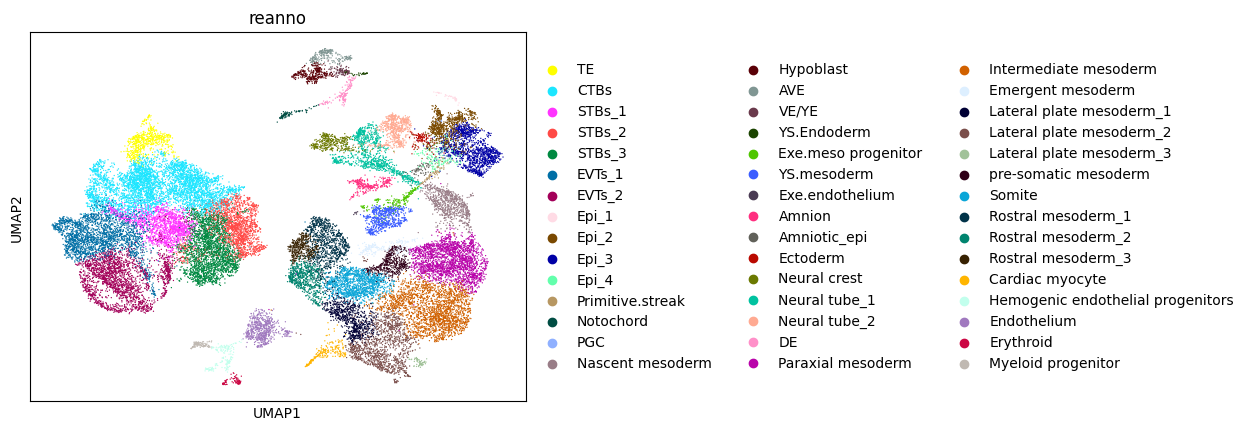

In [9]:
sc.pl.umap(human, color=['reanno']) #This was manually subclustered and labeled previously

In [10]:
%matplotlib inline

/home/liuxiaodongLab/fanxueying/miniconda3/envs/benchmarking/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


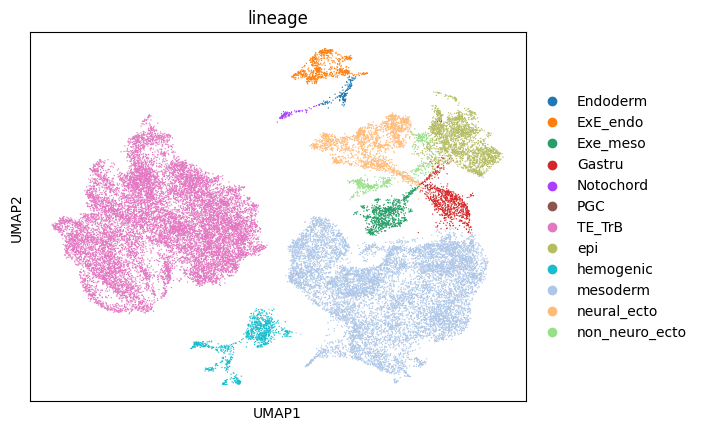

In [11]:
sc.pl.umap(human, color=['lineage']) #This was manually subclustered and labeled previously

/home/liuxiaodongLab/fanxueying/miniconda3/envs/benchmarking/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


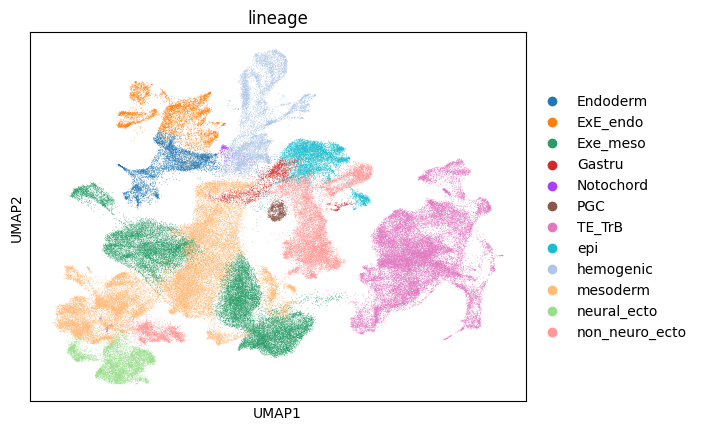

In [12]:
sc.pl.umap(monkey, color=['lineage']) #This was manually subclustered and labeled previously

/home/liuxiaodongLab/fanxueying/miniconda3/envs/benchmarking/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


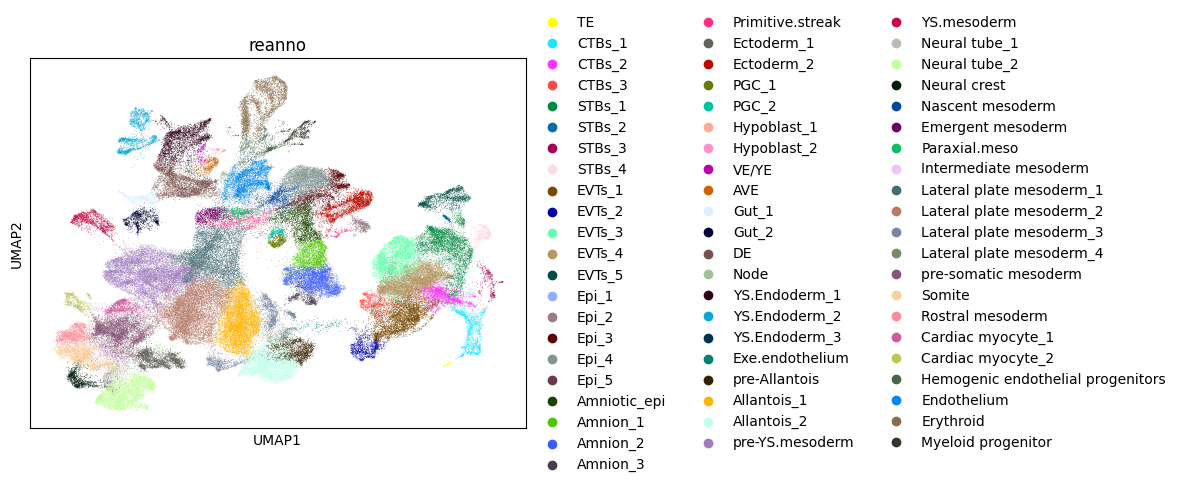

In [13]:
sc.pl.umap(monkey, color=['reanno']) #This was manually subclustered and labeled previously

In [14]:
# Proceed with computing average expression
def compute_average_expression(adata, cell_type_key):
    """
    Compute the average gene expression for each cell type using HVGs.
    
    Returns:
        A DataFrame with cell types as rows and genes as columns.
    """
    if cell_type_key not in adata.obs:
        print(f"Key '{cell_type_key}' not found in adata.obs. Available keys are: {adata.obs.keys()}")
        return None

    # Filter to only include highly variable genes
    hvg_genes = adata.var_names[adata.var['highly_variable']]
    
    # Ensure the data is in a pandas DataFrame and filter for HVGs
    try:
        expr_df = pd.DataFrame(adata[:, hvg_genes].X.toarray(), index=adata.obs_names, columns=hvg_genes)
    except Exception as e:
        print(f"Error converting AnnData.X to DataFrame: {e}")
        return None
    
    # Add cell type annotations
    expr_df[cell_type_key] = adata.obs[cell_type_key].values
    
    # Group by cell type and compute the mean
    try:
        avg_expr = expr_df.groupby(cell_type_key).mean()
        print(f"Computed average expression for {adata.shape[0]} cells and {len(hvg_genes)} HVGs.")
        return avg_expr
    except Exception as e:
        print(f"Error computing average expression: {e}")
        return None

# Compute average expression for both datasets using HVGs
human_avg_expr = compute_average_expression(human, 'reanno')
monkey_avg_expr = compute_average_expression(monkey, 'reanno')
#monkey_avg_expr = compute_average_expression(monkey, 'leiden_3') #for checking monkey clusters

# 3. Align Genes Between Datasets
if human_avg_expr is not None and monkey_avg_expr is not None:
    # Find the intersection of HVGs present in both datasets
    common_genes = human_avg_expr.columns.intersection(monkey_avg_expr.columns)
    print(f"Number of common HVGs: {len(common_genes)}")
    
    # Filter the average expression DataFrames to only include common HVGs
    human_avg_expr_filtered = human_avg_expr[common_genes]
    monkey_avg_expr_filtered = monkey_avg_expr[common_genes]
else:
    print("Failed to compute average expression for one or both datasets.")


Computed average expression for 33406 cells and 2000 HVGs.
Computed average expression for 141868 cells and 2000 HVGs.
Number of common HVGs: 944


In [15]:
# 4. Compute Correlation Matrix
correlation_matrix = pd.DataFrame(
    index=human_avg_expr_filtered.index,
    columns=monkey_avg_expr_filtered.index,
    dtype=float
)

# Compute Pearson correlation between each pair of cell types
for human_cell_type in human_avg_expr_filtered.index:
    for monkey_cell_type in monkey_avg_expr_filtered.index:
        human_profile = human_avg_expr_filtered.loc[human_cell_type]
        monkey_profile = monkey_avg_expr_filtered.loc[monkey_cell_type]
        corr_coef = human_profile.corr(monkey_profile, method='pearson')
        correlation_matrix.loc[human_cell_type, monkey_cell_type] = corr_coef

# Ensure no NaN or infinite values in the correlation matrix
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)


<Figure size 2000x1500 with 0 Axes>

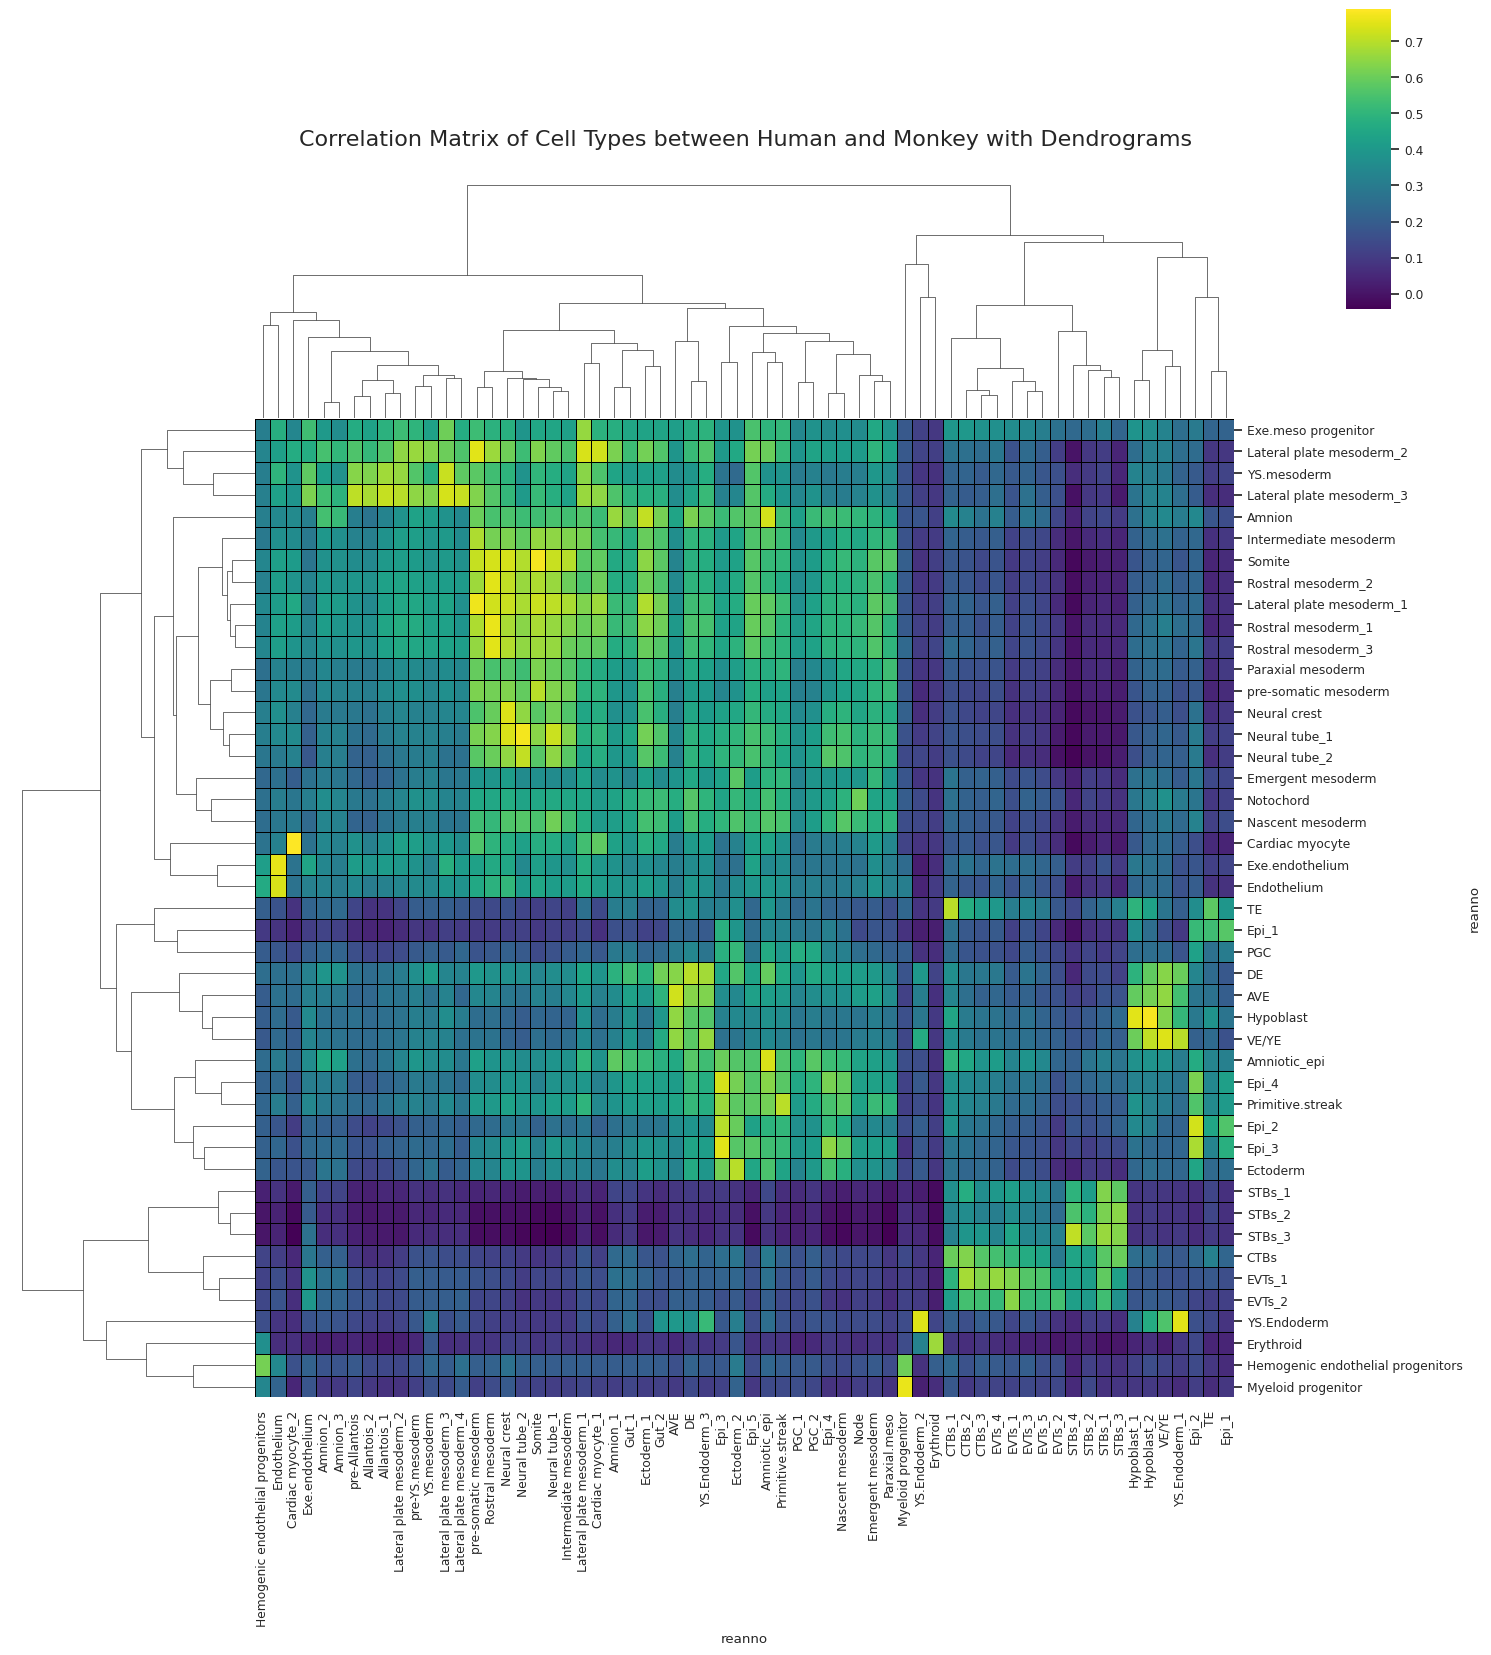

In [16]:
# 5. Plot Correlation Matrix with Dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are saved as text, not outlines
plt.rcParams['font.sans-serif'] = ['Arial']  # Use Arial or another common font

plt.figure(figsize=(20, 15))
sns.set(font_scale=0.8)

g = sns.clustermap(correlation_matrix, 
                   annot=False,
                   fmt=".2f", 
                   cmap='viridis',
                   xticklabels=monkey_avg_expr_filtered.index,
                   yticklabels=human_avg_expr_filtered.index,
                   figsize=(15, 15),
                   dendrogram_ratio=(0.2, 0.2),
                   cbar_pos=(0.9, 0.9, 0.03, 0.2),
                   linewidths=0.5,
                   linecolor='black')

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

g.fig.suptitle('Correlation Matrix of Cell Types between Human and Monkey with Dendrograms', 
               fontsize=16, y=1.02)

plt.show()
# Export the plot as a PDF and PNG
g.fig.savefig('correlation_matrix_dendrogram.pdf', dpi=300, bbox_inches='tight')